In [ ]:
#!apt update && apt install -y r-base

In [ ]:
#%load_ext rpy2.ipython

In [ ]:
#Carga de librerías
install.packages("naniar")
#install.packages("VIM", dependencies = TRUE)
library(dplyr)
library(ggplot2)
library(tidyr)
library(naniar)
#library(VIM)
#generar dataset en base al CSV
df <- read.csv("/content/sample_data/demo_proyecto_smart_alerts.csv", header = TRUE, sep = ";")

# Información del dataset
str(df)        # estructura del dataset

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




'data.frame':	62558 obs. of  43 variables:
 $ cod_comercio               : int  5599301 5599358 5599326 5599382 5599383 5599426 5599447 5599443 5599681 5599578 ...
 $ cod_situacion_comercio     : int  6 1 1 1 1 6 6 6 6 6 ...
 $ desc_situacion_comercio    : chr  "CÓDIGO SIN TRANSACCIONES POR MÁS DE 6 MESES (SÍ HAN TRANSACCIONADO ANTES)" "CÓDIGO ACTIVO (TRANSACCIONÓ EN LOS ÚLTIMOS 3 MESES)" "CÓDIGO ACTIVO (TRANSACCIONÓ EN LOS ÚLTIMOS 3 MESES)" "CÓDIGO ACTIVO (TRANSACCIONÓ EN LOS ÚLTIMOS 3 MESES)" ...
 $ tipo_documento             : chr  "RUC" "RUC" "RUC" "RUC" ...
 $ subtipo_documento          : chr  "RUC 10" "RUC 10" "RUC 10" "RUC 20" ...
 $ moneda_comercio            : chr  "SOLES" "SOLES" "SOLES" "SOLES" ...
 $ cod_giro_comercio          : int  5813 5999 5251 5941 5941 7011 5812 5812 5947 7032 ...
 $ nom_giro_comercio          : chr  "BARES, DISCOTECAS, KARAOKE" "OTRAS TIENDAS MINORISTAS" "FERRETERIA" "EQUIPOS PARA DEPORTE" ...
 $ com_visa_credito           : num  3.44 3.44 3.44 3.44 

In [ ]:

# 1. crear patron por linea

patterns <- df %>%
  mutate(across(everything(), ~ifelse(is.na(.), 1, 0))) %>%
  unite("pattern", everything(), sep = "")

# 2. Cuenta de frecuencias patrones
pattern_counts <- patterns %>%
  count(pattern, sort = TRUE)

cat("Número de patrones distintos de datos perdidos: ", nrow(pattern_counts), "\n")
cat("Patrón más frecuente:\n")
print(head(pattern_counts, nrow(pattern_counts)))

Número de patrones distintos de datos perdidos:  6 
Patrón más frecuente:
                                      pattern     n
1 0000000000000000000000000000000000000000000 36201
2 0000000000000000000000100000000000000000000 26296
3 0000000011000000000000100000000000000000000    39
4 0000000011000000000000000000000000000000000    20
5 0000000001000000000000000000000000000000000     1
6 0000000001000000000000100000000000000000000     1


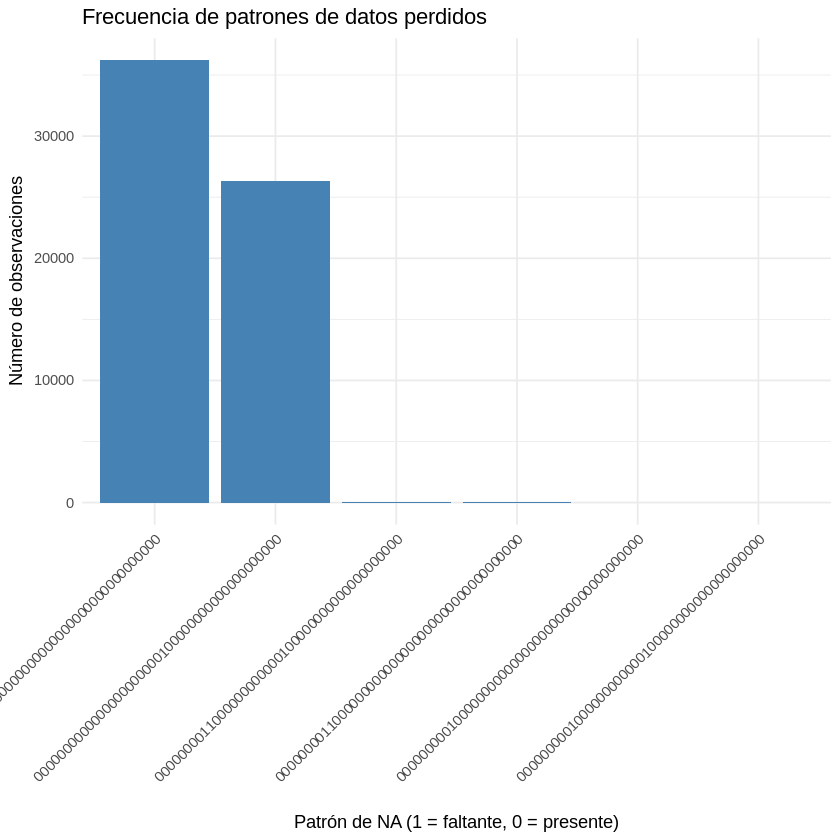

In [ ]:
library(ggplot2)

ggplot(pattern_counts, aes(x = reorder(pattern, -n), y = n)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(title = "Frecuencia de patrones de datos perdidos",
       x = "Patrón de NA (1 = faltante, 0 = presente)",
       y = "Número de observaciones") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

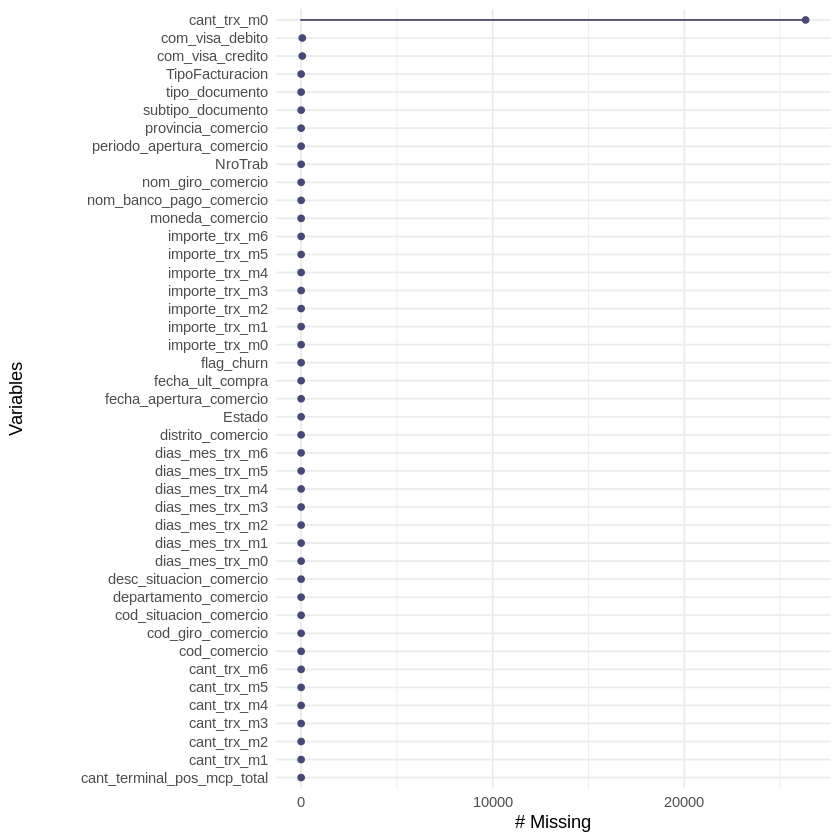

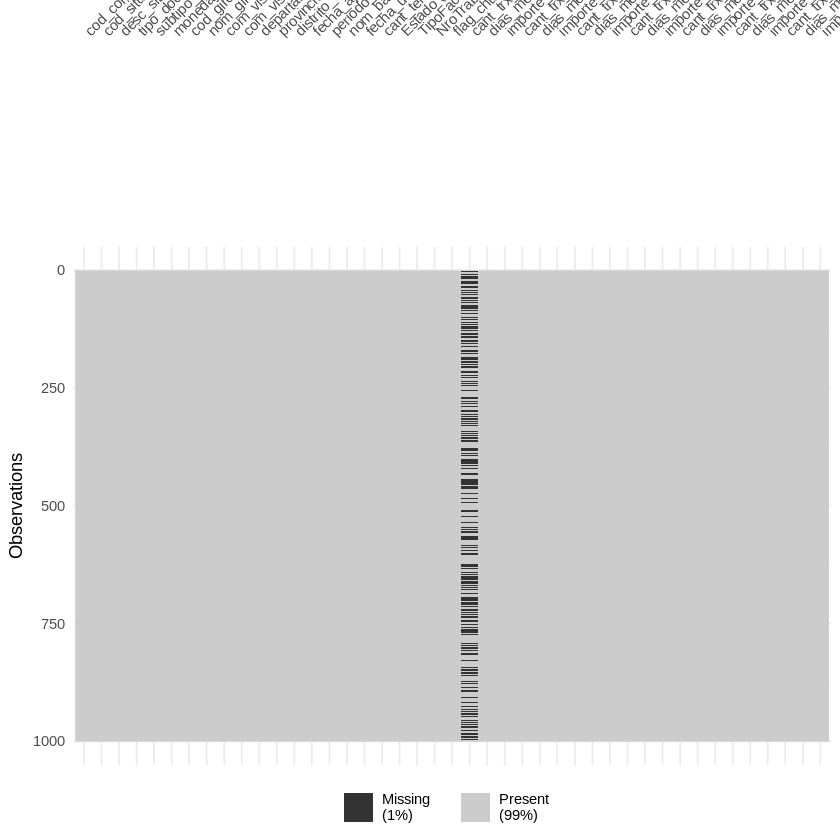

In [ ]:
# cuántos NA por variable
gg_miss_var(df)

# mapa de calor de los NA
# Sample a subset of the data for visualization
set.seed(123) # for reproducibility
df_sample <- df[sample(nrow(df), 1000), ] # Sample 1000 rows
vis_miss(df_sample)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

corrplot 0.95 loaded



     cod_comercio cod_situacion_comercio cod_giro_comercio com_visa_credito
1         5599301                      6              5813             3.44
2         5599358                      1              5999             3.44
3         5599326                      1              5251             3.44
4         5599382                      1              5941             3.44
5         5599383                      1              5941             3.44
6         5599426                      6              7011             3.44
7         5599447                      6              5812             3.44
8         5599443                      6              5812             3.44
9         5599681                      6              5947             3.44
10        5599578                      6              7032             3.44
11        5599511                      6              4812             3.44
12        5599616                      6              5251             3.09
13        55

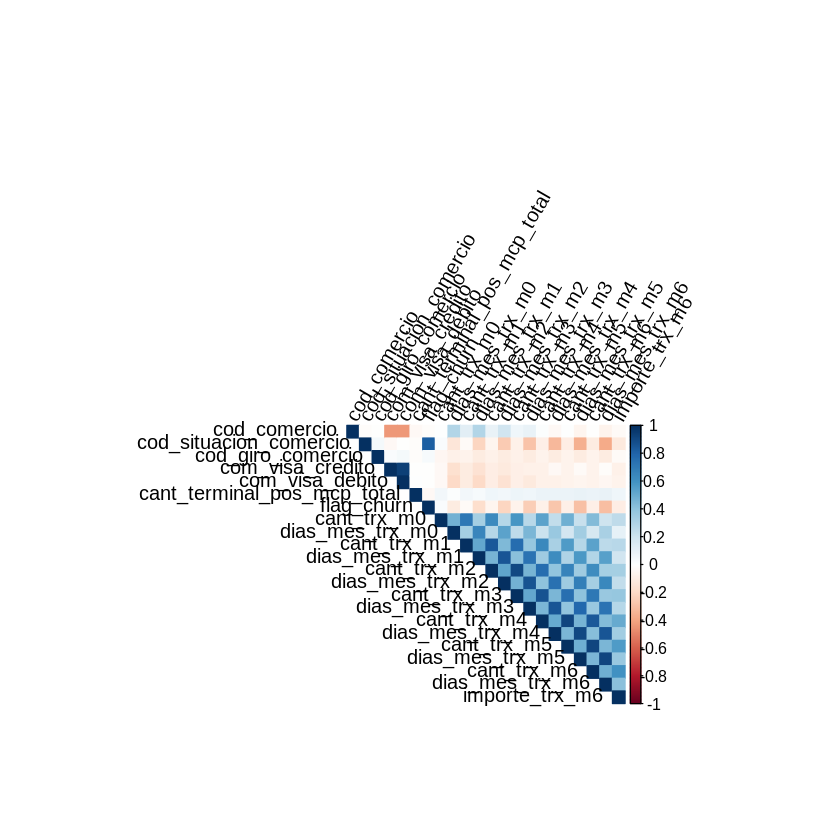

In [ ]:
install.packages("corrplot")
library(corrplot)
num_df <- df[sapply(df, is.numeric)]
corr_matrix <- cor(num_df, use = "pairwise.complete.obs") # Calculate correlation matrix, handling missing values
print(num_df)

corrplot(corr_matrix, method = "color", type = "upper",
         tl.col = "black", tl.srt = 60)

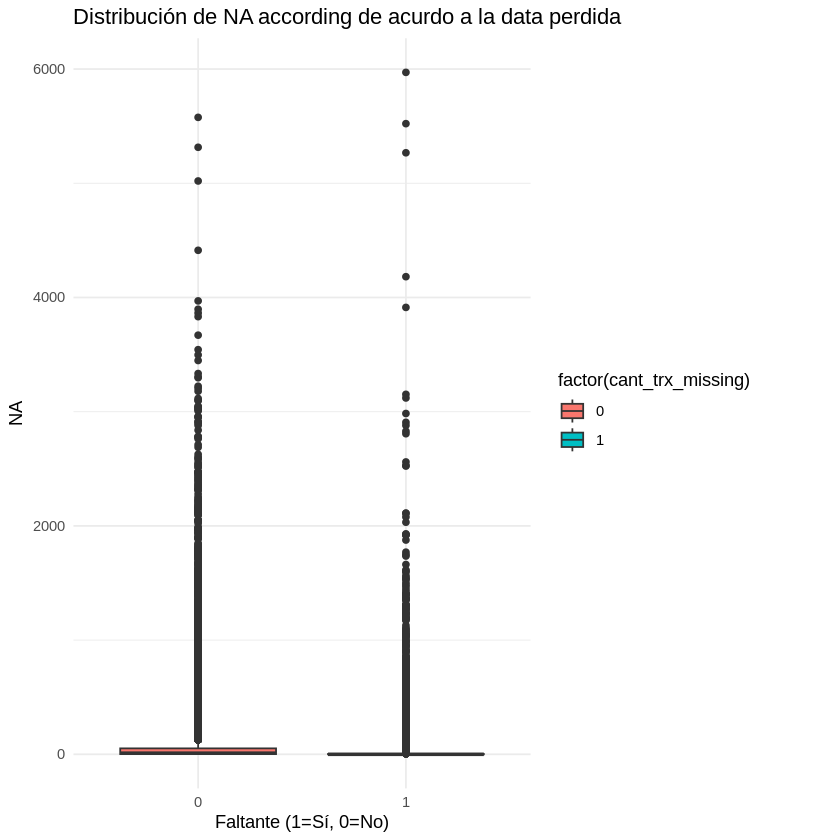

In [ ]:
# 1. Variable indicador de NA
df <- df %>%
  mutate(cant_trx_missing = ifelse(is.na(cant_trx_m0), 1, 0))

ggplot(df, aes(x = factor(cant_trx_missing), y = cant_trx_m1, fill = factor(cant_trx_missing))) +
  geom_boxplot() +
  labs(title = "Distribución de NA according de acurdo a la data perdida",
       x = "Faltante (1=Sí, 0=No)",
       y = "NA") +
  theme_minimal()

In [ ]:
t.test(cant_trx_m1 ~ cant_trx_missing, data = df)


	Welch Two Sample t-test

data:  cant_trx_m1 by cant_trx_missing
t = 38.742, df = 59827, p-value < 2.2e-16
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 54.89350 60.74366
sample estimates:
mean in group 0 mean in group 1 
       81.72172        23.90314 


In [ ]:
install.packages(c("ggplot2", "dplyr", "caret"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Instalar paquetes
install.packages("mice")
library(mice)

df_impute <- df %>%
  select(cant_trx_m0, cant_trx_m1) # Select columns to impute

imputed_data <- mice(df_impute, m = 5, method = 'pmm', seed = 123)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




 iter imp variable
  1   1  cant_trx_m0
  1   2  cant_trx_m0
  1   3  cant_trx_m0
  1   4  cant_trx_m0
  1   5  cant_trx_m0
  2   1  cant_trx_m0
  2   2  cant_trx_m0
  2   3  cant_trx_m0
  2   4  cant_trx_m0
  2   5  cant_trx_m0
  3   1  cant_trx_m0
  3   2  cant_trx_m0
  3   3  cant_trx_m0
  3   4  cant_trx_m0
  3   5  cant_trx_m0
  4   1  cant_trx_m0
  4   2  cant_trx_m0
  4   3  cant_trx_m0
  4   4  cant_trx_m0
  4   5  cant_trx_m0
  5   1  cant_trx_m0
  5   2  cant_trx_m0
  5   3  cant_trx_m0
  5   4  cant_trx_m0
  5   5  cant_trx_m0


In [ ]:
# Evaluar missing values antes de la imputación
cat("Missing values in cant_trx_m0 before imputation:", sum(is.na(df$cant_trx_m0)), "\n")

# Evaluar missing values después de la imputación
cat("Missing values in cant_trx_m0 after imputation (dataset 1):", sum(is.na(complete(imputed_data, 1)$cant_trx_m0)), "\n")

Missing values in cant_trx_m0 before imputation: 26336 
Missing values in cant_trx_m0 after imputation (dataset 1): 0 


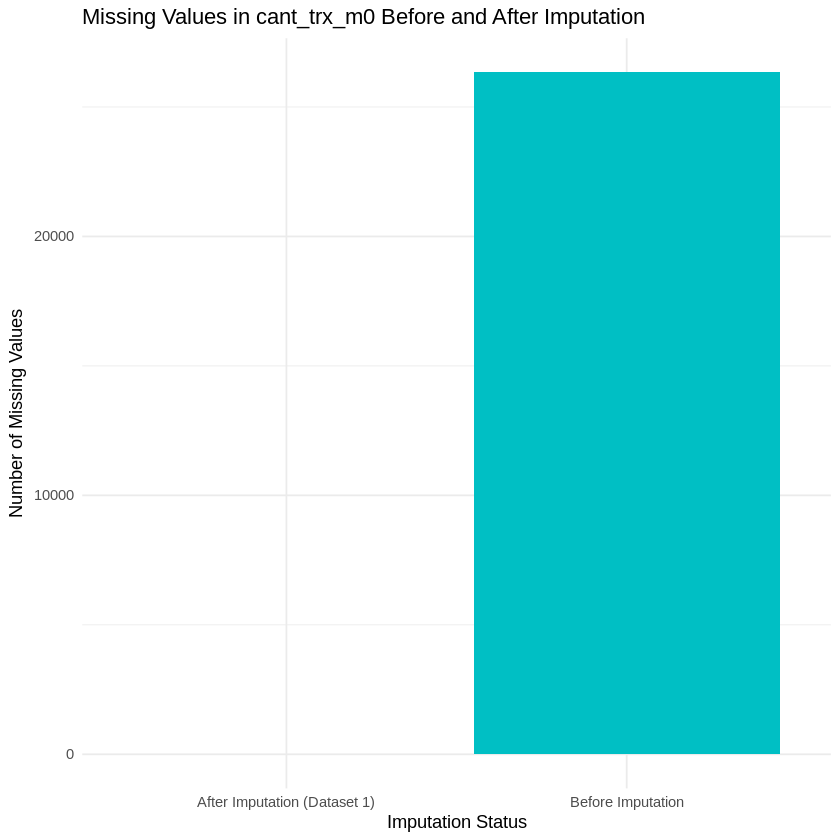

In [ ]:
missing_counts <- data.frame(
  Imputation_Status = c("Before Imputation", "After Imputation (Dataset 1)"),
  Missing_Count = c(sum(is.na(df$cant_trx_m0)), sum(is.na(complete(imputed_data, 1)$cant_trx_m0)))
)

missing_counts$Imputation_Status <- factor(missing_counts$Imputation_Status, levels = c("After Imputation (Dataset 1)", "Before Imputation"))

# Crear gráfico de barras
ggplot(missing_counts, aes(x = Imputation_Status, y = Missing_Count, fill = Imputation_Status)) +
  geom_bar(stat = "identity") +
  labs(title = "Missing Values in cant_trx_m0 Before and After Imputation",
       x = "Imputation Status",
       y = "Number of Missing Values") +
  theme_minimal() +
  theme(legend.position = "none") # Remove legend as fill is self-explanatory

Basado en el análisis realizado, el proceso de imputación múltiple abordó con éxito los valores faltantes en la variable `cant_trx_m0`. Como se observa en los resultados, la cantidad de valores faltantes se redujo significativamente, pasando de 26,336 antes de la imputación a 0 en el primer conjunto de datos imputado. Esto demuestra que el método de imputación múltiple utilizando el paquete `mice` con el método 'pmm' fue efectivo para completar los datos ausentes en esta variable, permitiendo así un análisis más completo en las etapas subsiguientes.

# Task
Perform a univariate or multivariate outlier analysis on the dataset, selecting the necessary attributes and justifying the choice.

In [ ]:
# Select the 'cant_trx_m*' columns for outlier analysis
cant_trx_cols <- select(df, starts_with("cant_trx_m"))

# Function to detect outliers using IQR
detect_outliers_iqr <- function(x) {
  q1 <- quantile(x, 0.25, na.rm = TRUE)
  q3 <- quantile(x, 0.75, na.rm = TRUE)
  iqr <- q3 - q1
  lower_bound <- q1 - 1.5 * iqr
  upper_bound <- q3 + 1.5 * iqr
  outliers <- x[x < lower_bound | x > upper_bound]
  return(outliers)
}

# Apply the outlier detection function to each 'cant_trx_m*' column
outliers_list <- lapply(cant_trx_cols, detect_outliers_iqr)

# Print the number of outliers found in each column
for (col_name in names(outliers_list)) {
  cat("Number of outliers in", col_name, ":", length(outliers_list[[col_name]]), "\n")
  # Optionally, print the outlier values
  # cat("Outliers in", col_name, ":", outliers_list[[col_name]], "\n")
}

Number of outliers in cant_trx_m0 : 31513 
Number of outliers in cant_trx_m1 : 10120 
Number of outliers in cant_trx_m2 : 9879 
Number of outliers in cant_trx_m3 : 9885 
Number of outliers in cant_trx_m4 : 9612 
Number of outliers in cant_trx_m5 : 9765 
Number of outliers in cant_trx_m6 : 9892 


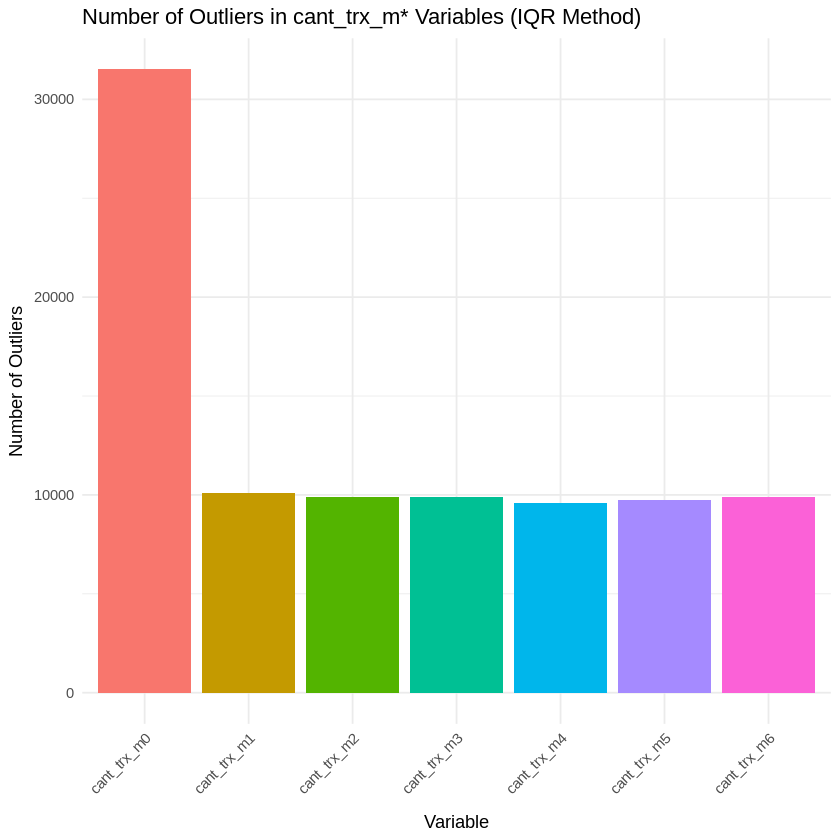

In [ ]:
# Create a data frame from the outliers_list for plotting
outlier_counts_df <- data.frame(
  Variable = names(outliers_list),
  Outlier_Count = sapply(outliers_list, length)
)

# Create a bar chart
ggplot(outlier_counts_df, aes(x = Variable, y = Outlier_Count, fill = Variable)) +
  geom_bar(stat = "identity") +
  labs(title = "Number of Outliers in cant_trx_m* Variables (IQR Method)",
       x = "Variable",
       y = "Number of Outliers") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) + # Rotate x-axis labels for readability
  theme(legend.position = "none") # Remove legend

Aquí tienes algunas conclusiones y recomendaciones basadas en el análisis de datos faltantes y valores atípicos en las variables `cant_trx_m*`:

**Conclusiones:**

*   Se identificó una cantidad significativa de valores faltantes en la variable `cant_trx_m0`.
*   El análisis de datos faltantes sugirió que la ausencia de datos en `cant_trx_m0` podría estar relacionada con los valores en `cant_trx_m1`, indicando un posible patrón de Missing At Random (MAR) o Missing Not At Random (MNAR).
*   La imputación múltiple utilizando el método 'pmm' fue efectiva para completar los valores faltantes en `cant_trx_m0`, resultando en un conjunto de datos completo para esta variable.
*   El análisis de valores atípicos reveló un número considerable de outliers en las variables `cant_trx_m*`, siendo `cant_trx_m0` la variable con la mayor cantidad de valores atípicos detectados por el método IQR.

**Recomendaciones:**

*   Investigar la causa raíz de los valores faltantes en `cant_trx_m0` para comprender mejor el proceso de recolección de datos y prevenir futuros datos ausentes.
*   Analizar a fondo los valores atípicos identificados en las variables `cant_trx_m*`, especialmente en `cant_trx_m0`, para determinar si son errores de entrada de datos, eventos excepcionales genuinos o si requieren un tratamiento específico (transformación, winsorización, etc.).
*   Considerar la aplicación de métodos de análisis robustos a los outliers para minimizar su impacto en los resultados si se decide no eliminarlos o transformarlos.
*   Continuar con el análisis exploratorio de datos y el modelado utilizando los conjuntos de datos imputados, teniendo en cuenta las decisiones tomadas sobre el tratamiento de outliers.

Aquí tienes algunas conclusiones y recomendaciones basadas en el análisis de datos faltantes y valores atípicos en las variables `cant_trx_m*`:

**Conclusiones:**

*   Se identificó una cantidad significativa de valores faltantes en la variable `cant_trx_m0`.
*   El análisis de datos faltantes sugirió que la ausencia de datos en `cant_trx_m0` podría estar relacionada con los valores en `cant_trx_m1`, indicando un posible patrón de Missing At Random (MAR) o Missing Not At Random (MNAR).
*   La imputación múltiple utilizando el método 'pmm' fue efectiva para completar los valores faltantes en `cant_trx_m0`, resultando en un conjunto de datos completo para esta variable.
*   El análisis de valores atípicos reveló un número considerable de outliers en las variables `cant_trx_m*`, siendo `cant_trx_m0` la variable con la mayor cantidad de valores atípicos detectados por el método IQR.
*   La distribución de los valores atípicos en `cant_trx_m0` podría indicar eventos inusuales o un cambio en el comportamiento de las transacciones en ese período específico.
*   La relación observada entre los valores faltantes en `cant_trx_m0` y los valores presentes en `cant_trx_m1` (identificada a través del t-test y boxplot) es crucial para entender el patrón de datos faltantes y justificar la elección de un método de imputación como 'pmm'.

**Recomendaciones:**

*   Investigar la causa raíz de los valores faltantes en `cant_trx_m0` para comprender mejor el proceso de recolección de datos y prevenir futuros datos ausentes.
*   Analizar a fondo los valores atípicos identificados en las variables `cant_trx_m*`, especialmente en `cant_trx_m0`, para determinar si son errores de entrada de datos, eventos excepcionales genuinos o si requieren un tratamiento específico (transformación, winsorización, etc.).
*   Considerar la aplicación de métodos de análisis robustos a los outliers para minimizar su impacto en los resultados si se decide no eliminarlos o transformarlos.
*   Continuar con el análisis exploratorio de datos y el modelado utilizando los conjuntos de datos imputados, teniendo en cuenta las decisiones tomadas sobre el tratamiento de outliers.
*   Explorar si existe alguna correlación entre la aparición de outliers en `cant_trx_m0` y otras características de los comercios (como tipo de comercio, ubicación, etc.) para identificar posibles factores contribuyentes.

Here is the bibliography in alphabetical order (APA 7 format):

*   Grolemund, G., & Wickham, H. (2017). *R for data science: Import, tidy, transform, visualize, and model data*. O'Reilly Media.
*   Little, R. J. A., & Rubin, D. B. (2002). *Statistical analysis with missing data* (2nd ed.). John Wiley & Sons.
*   Moore, D. S., McCabe, G. P., & Craig, B. A. (2017). *Introduction to the practice of statistics* (9th ed.). W.H. Freeman.
*   Rubin, D. B. (1987). *Multiple imputation for nonresponse in surveys*. John Wiley & Sons.
*   Tukey, J. W. (1977). *Exploratory data analysis*. Addison-Wesley.
*   Van Buuren, S. (2018). *Flexible imputation of missing data*. CRC Press.
*   Van Buuren, S., & Groothuis-Oudshoorn, K. (2011). `mice`: Multivariate imputation by chained equations in R. *Journal of Statistical Software*, *45*(3), 1-67.
*   Wickham, H. (2016). *ggplot2: Elegant graphics for data analysis*. Springer.
*   Wickham, H., François, R., Robinson, D., & Yu, K. (2023). *dplyr: A grammar of data manipulation*. R package version 1.1.4.